# Exercise 12.2 - Galerkin method applied to the Kuramoto Sivashinsky dynamical system

In [1]:
# Import some necessary libraries
import numpy as np
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from scipy.integrate import odeint, solve_ivp

# Import plotting tools.
import matplotlib.pyplot as plt
# from IPython.display import HTML
# from matplotlib.animation import FuncAnimation

## Short teorethical summary

In exercise 12.2 the Galerkin method is used to solve the Kuramoto Sivashinsky PDE in a reduced space i.e. as a Reduced Order Model (ROM):

$$ u_t = - u_{xx} - u_{xxxx} - u\cdot u_{x} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,(1)$$

$$ u(x,t) \sim \sum_{k = 0}^n a_k(t)\psi_k(x) \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,(2) $$

Here, $\psi_0(x),...,\psi_n(x)$ are orthonormal basis modes and $a_j(t)$ a time dependent modal amplitude. By expressing the PDE in terms of Orthonormal modes and amplitudes the PDE can be linearized and solved as a system of ODEs.

By inserting the Galerkin expansion (2) pinto the governing equation (1) the **Galerkin projected dynamic** of the system is obtained. Further applying Sturm-Liouviulle theory to separate the linear and Non-linear parts of the system the following expansion is obtained:

$$
\frac{da(t)}{dt} = \Psi^TL\Psi a(t) + \Psi^TN(\Psi a(t), \beta) 
$$

## Data generation

Before the data driven methods can be applied synthetic data has to be generated. 

As first step, we use the **FFT method** to compute the solution of the Kuramoto Sivashinsky equation numerically, with:
- $t\in[0,100]$ , $dt = 0.24$ , for a total of $400$ evaluation points. 
- $x\in[0,100]$ , $dx \sim 0.1$ , for a total of $1024$ evaluation points. 

**Note about the code:** This way of solving the system is quite slow because it requires many evaluations of the system. In Kutz implementation he stays in the frequency space and only evaluates the time space every $n$ evaluations.

In [2]:
%%time
# Function which defines RHS of ODE system using the FFT.
def RHS_KS( u , t, kappa ):
    
    """
    INPUTS:
    u (np array) : starting conditions.
    t (scalar) : time step.
    kappa (np array) : wavenumbers.
    
    OUTPUT:
    du_dt (np array) : temporal derivative at time t.
    """
    
    # map into the Fourier space.
    uhat = np.fft.fft(u)  
    uhat_x = ( 1j ) * kappa * uhat 
    uhat_xx = np.power( ( 1j ) * kappa , 2 ) * uhat
    uhat_xxxx = np.power( ( 1j ) * kappa , 4 ) * uhat
    # map outside the Fourier space.
    u_x = np.fft.ifft( uhat_x )
    u_xx = np.fft.ifft( uhat_xx )
    u_xxxx = np.fft.ifft( uhat_xxxx )
    du_dt = - u_xx - u_xxxx - u_x * u
    
    return du_dt.real 

# Define the problem constants.                 
N = 1024
T = 100                 
x = 32 * np.pi * np.arange( 1 , N + 1 ) / N
dt = 0.25
t = np.arange( 0 , T , dt )

# Define discrete wavenumbers.
kappa = np.concatenate( ( np.arange( 0 , N // 2 ), [0] , np.arange( - N // 2 + 1 , 0 ) ) ) / 16 

# Define the starting conditions.
u0 = np.cos( x / 16 ) * ( 1 + np.sin( x / 16 ) )

# Simulate in Fourier frequency domain.
u = odeint( RHS_KS , u0 , t , args = ( kappa , ) ) 
u = u.T

CPU times: user 24min 19s, sys: 8min 45s, total: 33min 5s
Wall time: 2min 1s


The solution can be visualized in the plots below from two different perspectives.

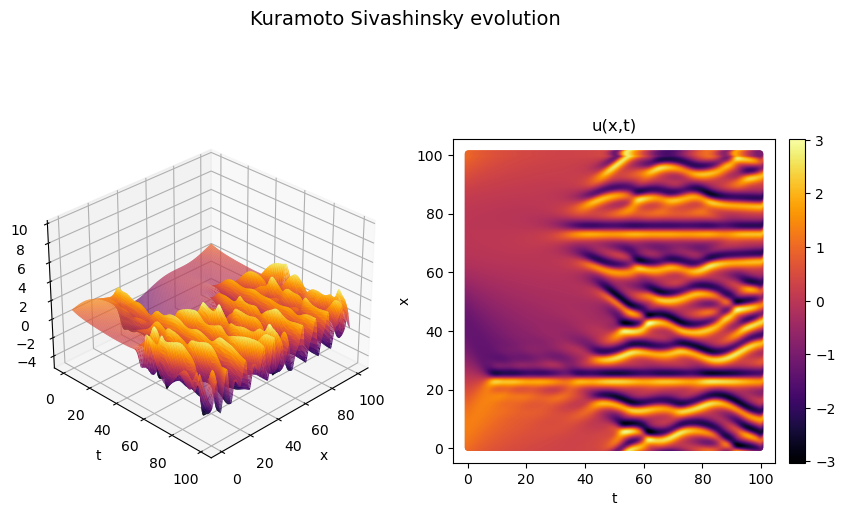

In [3]:
# Plot function.
def plot1( x , t , u ):
    
    """ This function plot the solution of the Kuramato Sivashinsky equation """

    fig = plt.figure( figsize = ( 10 , 6 ) )
    ax1 = fig.add_subplot( 121 , projection = '3d' )
    ax2 = fig.add_subplot( 122 )
    time , space = np.meshgrid( t , x )
    ax1.plot_surface( space , time , u , cmap = 'inferno' , rstride = 3, cstride = 3, antialiased = True )
    ax1.invert_xaxis()
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_zlabel('u(x,t)')
    ax1.set_zlim( -5 , 10 )
    ax1.view_init( 30 , 45 )
    s = ax2.scatter( time , space , c = u , cmap = "inferno", marker = ".", edgecolor = None)
    ax2.set_xlabel("t")
    ax2.set_ylabel("x")
    ax2.set_title("u(x,t)")
    cbar = fig.colorbar( s ,fraction = 0.046, pad = 0.04)
    ax2.set_aspect('equal', 'box')
    
    fig.suptitle( "Kuramoto Sivashinsky evolution", fontsize = 14)
    fig.subplots_adjust(top=0.88)
    plt.show()
    
    return 0
    
# Plot the solution u(x,t)    
_ = plot1( x , t , u )

## (a) POD
The objective of this exercise is to compute the leading POD modes of the Kuramoto Sivashinsky solution and produce a rank-r Galerkin-POD approximation of the equation evolution.

SVD is used to obtain the modes (also see exercise 1.7 on SVD).

$$u(x,t) = U \Sigma V^*$$

$$U = \begin{bmatrix} | & | & | \\ \psi_0 & ... & \psi_n \\ | & | & | \end{bmatrix}$$

We compute the SVD of the Kuramoto Sivashinsky equation and plot both the *singular value spectrum* and its *cumulative function*. Then, we search the rank $r$ which allows to retain the $99.X\%$ of the information.

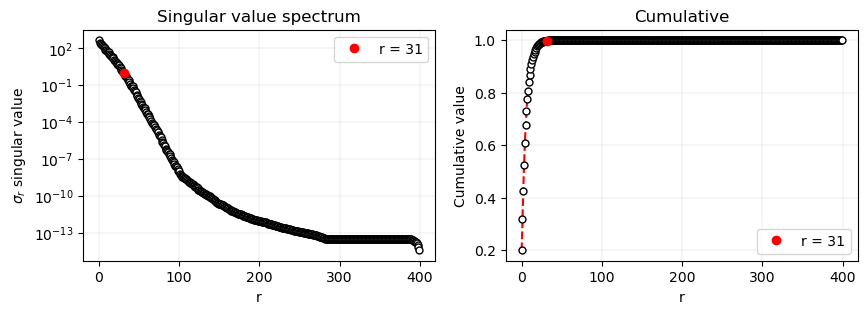

In [4]:
# Function which compute the SVD of a system.
def SVD( u ):
    
    """
    INPUTS:
    u (np array) : matrix with PDE solution.
    
    OUTPUT:
    U (np array) : left singular values.
    S (np array) : array with eigenvalues ordered from the most to the less important.
    Sd (np array) : matrix with eigenvalues on the diagonal and 0 elsewhere.
    VT (np array) : complex conjugate of right singular values. 
    """    
    
    U, S, VT = np.linalg.svd( u ) 
    Sd = np.diag( S )
    
    return U , S , Sd , VT
    

# Function to find the rank which allows to retain the 99.X% of the system energy.
def SVD_rrank_approx( u , U , Sd , VT , reatined_energy ):
    
    """
    INPUTS:
    U (np array) : left singular values.
    S (np array) : array with eigenvalues ordered from the most to the less important.
    Sd (np array) : matrix with eigenvalues on the diagonal and 0 elsewhere.
    VT (np array) : complex conjugate of right singular values. 
    retained_energy (scalar) : percentage of the total energy that we want to retain in the approximation.
    
    OUTPUTS:
    R (int scalar) : rank value.
    psi (np array) : first R left singular values.
    u_R (np array) : r-rank reconstruction of u(x,t).
    """       
    
    Etot = np.linalg.norm( u , 'fro' ) ** 2
    ER = Etot * ( reatined_energy / 100 )

    for r in range( N ):    
        # Compute the r-rank approximation.
        Rrank_approx = U[ : , :r ] @ Sd[ 0:r , :r ] @ VT[ :r , : ]                     
        # Compute the Frobenius norm.
        Rrank_energy = np.linalg.norm( Rrank_approx , 'fro' ) ** 2
        # Implement the inequality.
        if Rrank_energy >= ER:
            R = r + 1
            psi = U[ : , :r ]
            u_R = Rrank_approx
            break
    
    return R , psi , u_R

# Plot function.
def plot2( S ):
    
    """ This function plots the SVD spectrum and its cumulative function """

    X = np.arange( len(S) , dtype = "float64" )
    y1 = np.array( S , dtype = "float64" )
    y2 = np.cumsum(S) / np.sum(S)

    plt.close()
    fig , (ax1, ax2) = plt.subplots( 1 , 2 , figsize = ( 10 , 3 ) )
    ax1.set_yscale('log')
    _ = ax1.plot( X , y1 , marker = 'o' , markersize = 5 ,
             markerfacecolor = 'white',  markeredgecolor = "black" , 
             linestyle = "--", color = "red" )
    ax1.plot( X[R] , y1[R] , 'o', color = "red", label = "r = " + str(R) )
    ax1.set_xlabel("r")
    ax1.set_ylabel("$\sigma_{r}$ singular value")
    ax1.set_title("Singular value spectrum")
    ax1.grid(color = 'gray', linestyle = '-' , linewidth = 0.1 )
    ax1.legend( loc = "upper right" )
    _ = ax2.plot( X , y2 , marker = 'o' , markersize = 5 ,
             markerfacecolor = 'white',  markeredgecolor = "black" , 
             linestyle = "--", color = "red" )
    ax2.plot( X[R] , y2[R] , 'o', color = "red", label = "r = " + str(R) )
    ax2.set_xlabel("r")
    ax2.set_ylabel("Cumulative value")
    ax2.set_title("Cumulative")
    ax2.grid(color = 'gray', linestyle = '-' , linewidth = 0.1 )
    ax2.legend( loc = "lower right" )
    plt.show()
    
    return 0

# Apply SVD to u(x,t).
U , S , Sd , VT = SVD( u )

# Define how much enrgy to retain in the u approximation.
rrank_energy = 99.999

# Find the rrank approximation which allows to retain the defined energy percentage.
R , psi , u_R = SVD_rrank_approx( u , U , Sd , VT , rrank_energy )

# Plot the Singular Value Spectrum and the Cumulative function.
_ = plot2(S)

We use the modes $\psi_0,...,\psi_n$ that we obtained by applying the SVD to $u(x,t)$ to produce its $r-rank$ Galerkin approximation. We compute the starting condition for $a_{r-rank}(0)$ as $a_{r-rank}(0) = \psi^{-1} u_{r-rank}(x,0)$ and we use it to reconstruct $u(x,0)$. Then we plot the two curves againts each other to demonstrate that the starting condition can be recovered nicely with the rank we choose. 

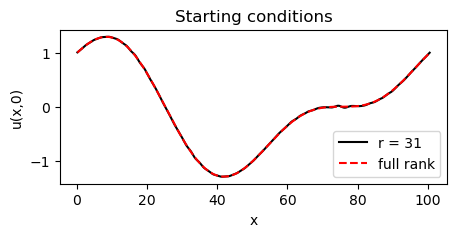

In [5]:
# Plot function.
def plot3( x , u_R0 , u0 ):
    
    """ This function plot the true strating conditios u(x,0) and its r-rank reconstruction. """

    plt.close()

    fig = plt.figure( figsize = ( 5 , 2 ) )
    _ = plt.plot( x , u_R0 , color = "black" , label = "r = " + str(R) )
    _ = plt.plot( x , u0  , color = "red" , linestyle = "--" , label = "full rank")
    plt.xlabel("x")
    plt.ylabel("u(x,0)")
    _ = plt.title("Starting conditions")
    plt.legend(loc = "lower right")
    plt.show()
    
    return 0

# Recover the starting condition for a.
psi_inverse = np.linalg.pinv( psi , rcond = 1e-15 , hermitian = False )
a0 = psi_inverse @ u_R[ : , 0 ] 

# Reconstruct the starting condition u0 and plot it..
u_R0 = psi @ a0
_ = plot3( x , u_R0 , u0 )

 
We define the RHS of the Galerkin decomposition of $u(x,t)$ using finite difference to compute derivatives and we integrate the system using the ```odeint``` method from ```scipy```, which provides us with $a_{r-rank}(t)$. The system dynamic approximated to the $r-rank$, $u_{r-rank}(x,t)$, is therefore fully reconstructed via:

$$
u_{r-rank}(x,t) = \Psi_{r-rank} a_{r-rank}(t)
$$

and again the result is plotted with the associated error.

In [6]:
%%time
class Galerkin_POD_KS:
    """A class to setup and solve the POD based Galerkin Kuramato-Sivishinsky system setup with Sturm-Liouville theory.
    This was made as a class to make it easiser to store pre-computed derivatives of the POD modes. (See exercise 6.1 for a deeper explanation of the KS system.)
    """
    def __init__(self, Psi, x):
        """Initialization of the parameters required and the pre-computable derivatives.
        """
        self.x = x
        self.Psi = Psi
        # Derivatives can be pre-computed for the linear part of the system this is due to the fact that linear systems can be superimposed.
        Psi_x = np.gradient(Psi, x, axis=0)             # Not required for the Linear operator and therefore not saved
        self.Psi_xx = np.gradient(Psi_x, x, axis=0)
        Psi_xxx = np.gradient(self.Psi_xx, x, axis=0)   # Not required for the KS equation hence not saved
        self.Psi_xxxx = np.gradient(Psi_xxx, x, axis=0)

    def L(self, a, t):
        """Linear operation of the KS system
            -u_xx - u_xxxx
            Note that the derivatives of the POD modes are pre-computed
            therefore the input can be "a".
        """
        return -self.Psi_xx @ a - self.Psi_xxxx @ a

    def N(self, u, t):
        """"Non-linear operation of the KS system
            u*u_x
            Note that the derivatives are not pre-computed due to the non-linearity 
            therefore the input has to be "u". (or at least the approximation of u (Psi @ a))
        """
        u_x = np.gradient(u, self.x)
        return -u*u_x

    def a_t(self, a, t):
        """RHS of the KS system written in the """
        return self.Psi.T @ self.L(a, t) + self.Psi.T @ self.N(self.Psi @ a, t)

GPOD_KS = Galerkin_POD_KS( psi , x )    # Initialize the class (pre-computes derivatives and stores x)
a_POD = odeint( GPOD_KS.a_t , a0, t )      # Solve the Galerkin POD system in the latent space
u_POD = np.dot( psi, a_POD.T )          # Apply the Galerkin method to obtain the approximation of the solution in the original space.

CPU times: user 14.2 s, sys: 696 ms, total: 14.9 s
Wall time: 1.49 s


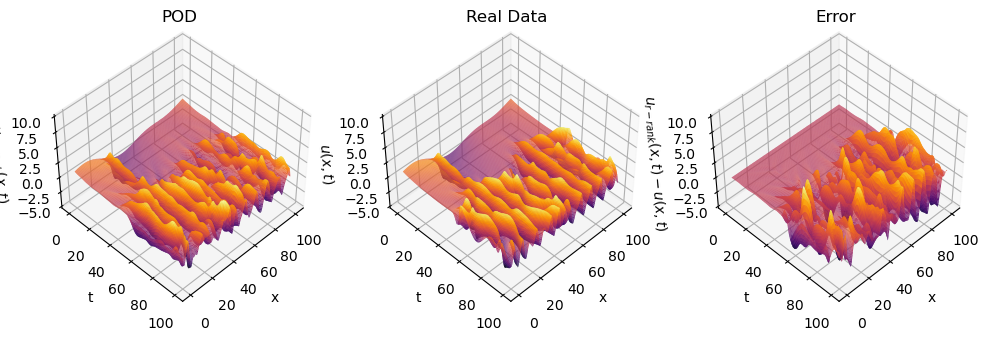

In [7]:
# Plot function.
def plot4( x , t , u , u_POD ):
    """ This function plot the POD of u(x,t), the original solution u(x,t) and the error between them """
    plt.close()

    # Plot the data.
    fig = plt.figure( figsize = ( 12 , 4 ) )
    ax1 = fig.add_subplot( 131 , projection = '3d' )
    ax2 = fig.add_subplot( 132 , projection = '3d' )
    ax3 = fig.add_subplot( 133 , projection = '3d' )
    time , space = np.meshgrid( t , x )

    for ax , uu , label , title in zip( [ ax1 , ax2 , ax3] , [ u_POD , u , u_POD - u ] , ['$u_{r-rank}(x,t)$' , '$u(x,t)$' , '$u_{r-rank}(x,t) - u(x,t)$'] , [ "POD" , "Real Data" , "Error" ]):

        ax.plot_surface( space , time , uu , cmap = 'inferno' , rstride = 3, cstride = 3, antialiased = True )
        ax.invert_xaxis()
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel( label )
        ax.set_title( title )
        ax.set_zlim( -5 , 10 )
        ax.view_init( 45 , 45 )
    
    return 0

_ = plot4( x , t , u , u_POD )

## (b)

Compute a ROM by using the snapshots to produce a rank-r DMD model to characterize the evolution. 

Avance the DMD method as presented in the book (page 269) and apply it to the solution of the Kuramoto Sivashinsky equation. Two dataset, out of phase of a single time-step one respect to the other, are defined and manipulated with DMD in order to recover $\Phi$, ( high dimensional DMD modes ), $\Lambda$ ( square matrix which contains the DMD eigenvalues on its diagonal ) and $b$ ( high dimensional mode amplitudes ).

In [8]:
def DMD( X , X_prime , r = 43 ):
    # STEP 1: compute the SVD of X and the r-rank approximation.
    U, S, VT = np.linalg.svd( X , full_matrices = True )
    Sd = np.diag( S )

    # R rank approximation.
    Ur = U[ : , :r ] 
    Sdr = Sd[ 0:r , :r ]
    VTr = VT[ :r , : ]

    # Hermitian of R rank approximations.
    Vr = VTr.T.conjugate() 
    UTr = Ur.T.conjugate()
    Sdr_inverse = np.linalg.inv( Sdr )

    # STEP 2: build the POD reconstruction of matrix A.
    Ar = UTr @ X_prime @ Vr @ Sdr_inverse
    A = X_prime @ Vr @ Sdr_inverse @ UTr # This is the full reconstruction of A and wants to be a demostration that eigenvalues stays the same. 

    # STEP 4: get the eigenvalues and eigenvectors of Ar and A respectively.
    Lambdas , W = np.linalg.eig( Ar )
    Lambdas_A , Phi = np.linalg.eig( A )


    # STEP 4: Phi reconstruction.
    Phi = X_prime @ Vr @ Sdr_inverse @ W
    
    return Phi , Lambdas , Lambdas_A , Ur , Ar , r

X = u[ : , :-1 ]
X_prime = u[ : , 1: ]

Phi , Lambdas , Lambdas_A , Ur , Ar , r = DMD( X , X_prime , r = 43 )

Perform dynamic diagnostic plotting the DMD modes and the DMD spectrum.

- Plot DMD modes, i.e. the eigenvector of the full matrix $A$.

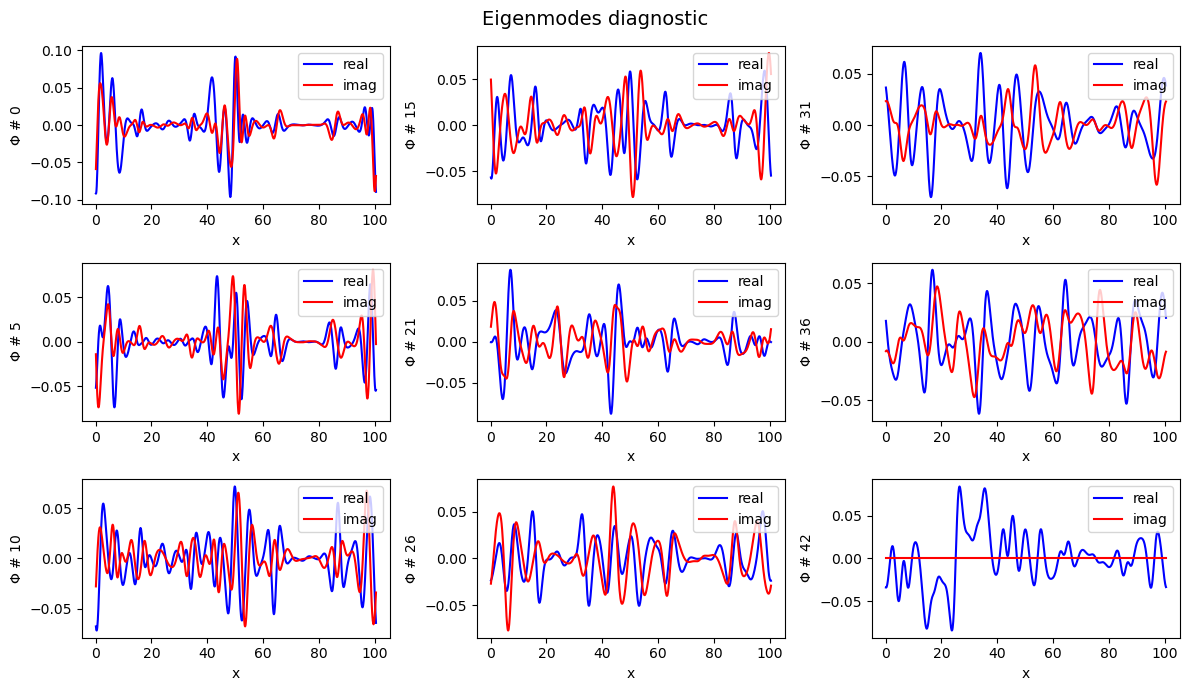

In [9]:
def plot5( x , Phi ):
    
    plt.close()
    fig , ax = plt.subplots( 3 , 3 , figsize = ( 12 , 7 ) )
    mode_num = np.linspace( 0 , 42 , 9 ).astype(int)
    kk = 0
    
    for jj in range(3):
        for ii in range(3):
            ax[ ii , jj ].plot( x , Phi[ : , mode_num[kk] ].real , c = "blue" , label = "real" )
            ax[ ii , jj ].plot( x , Phi[ : , mode_num[kk] ].imag , c = "red" , label = "imag" )
            ax[ ii , jj ].legend( loc = "upper right" )
            ax[ ii , jj ].set_xlabel( "x" )
            ax[ ii , jj ].set_ylabel( "$\Phi$ # " + str(mode_num[kk]) )
            kk = kk + 1
    
    fig.suptitle( "Eigenmodes diagnostic" , fontsize = 14 )
    fig.subplots_adjust(top=0.88)
    plt.tight_layout()        
    plt.show()

plot5( x , Phi )

- Plot DMD spectrum, i.e. the eigenvalues of the full matrix $A$.

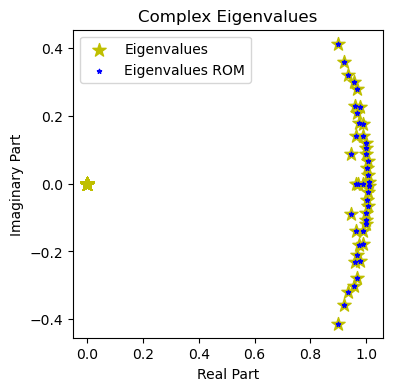

In [10]:
def plot6( Lambdas , Lambdas_A):
    # Extract real and imaginary parts
    Re_Ar = np.real(Lambdas)
    Im_Ar = np.imag(Lambdas)

    Re_A = np.real(Lambdas_A)
    Im_A = np.imag(Lambdas_A)

    # Create a scatter plot
    fig , ax = plt.subplots( 1 , 1 , figsize = ( 4 , 4 ) )
    ax.scatter( Re_A , Im_A , c = 'y', marker = '*' , s = 100 , label='Eigenvalues' )
    ax.scatter( Re_Ar , Im_Ar , c = 'b', marker = '*' , s = 10 , label='Eigenvalues ROM' )

    # Add labels and title
    ax.set_xlabel('Real Part')
    ax.set_ylabel('Imaginary Part')
    ax.set_title('Complex Eigenvalues')

    # Add legend
    ax.legend()

    # Show plot
    plt.show()
    
plot6( Lambdas , Lambdas_A )

Recontruct dynamic with the following workflow:
1) $\tilde{x}_0 = \tilde{U}^{-1}x$.

2) $\tilde{x}_k = \tilde{A}\tilde{x}_{k-1} \Rightarrow \tilde{X} = [\tilde{x}_0,...,\tilde{x}_T] $

3) $X_{DMD} = \tilde{U}\tilde{X}$

and plot the result.

In [11]:
# Reconstruction try 1.
xr_0 = np.linalg.pinv( Ur ) @ X[ : , 0 ]

Xr_DMD = np.zeros( ( r , len(t) ) )
Xr_DMD[ : , 0 ] = xr_0

for ii in range( 1 , len(t) , 1 ):
    Xr_DMD[ : , ii ] = Ar @ Xr_DMD[ : , ii - 1 ]
    
X_DMD = Ur @ Xr_DMD

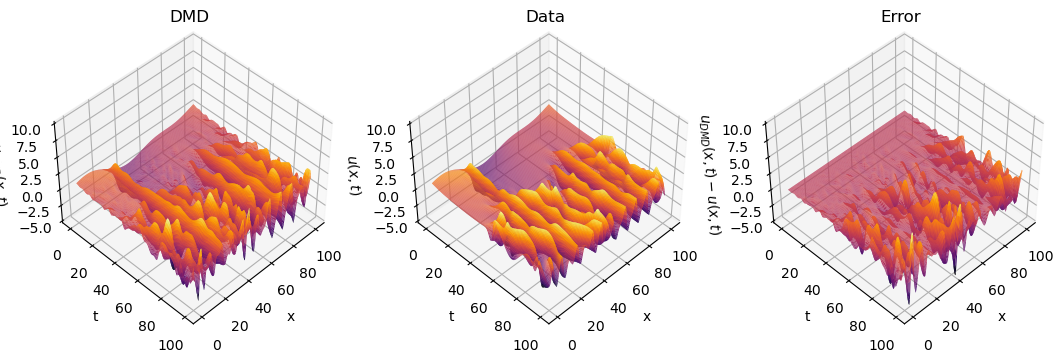

In [12]:
# Plot function.
def plot7( x , t , X_DMD , u ):
    
    """ This function plot the DMD of u(x,t), the original solution u(x,t) and the error between them """
    plt.close()

    # Plot the data.
    fig = plt.figure( figsize = ( 13 , 5 ) )
    ax1 = fig.add_subplot( 131 , projection = '3d' )
    ax2 = fig.add_subplot( 132 , projection = '3d' )
    ax3 = fig.add_subplot( 133 , projection = '3d' )
    time , space = np.meshgrid( t , x )

    for ax , uu , label , title in zip( [ ax1 , ax2 , ax3 ] , [ X_DMD , u , X_DMD - u] , ["$u_{DMD}(x,t)$" , "$u(x,t)$"  , "$u_{DMD}(x,t)- u(x,t)$" ] , [ "DMD" , "Data" , "Error" ]):

        ax.plot_surface( space , time , uu , cmap = 'inferno' , rstride = 3, cstride = 3, antialiased = True )
        ax.invert_xaxis()
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel( label )
        ax.set_title( title )
        ax.set_zlim( -5 , 10 )
        ax.view_init( 45 , 45 )
    
    return 0

_ = plot7( x , t , X_DMD , u )